In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
data_dir = "crop-disease-data"

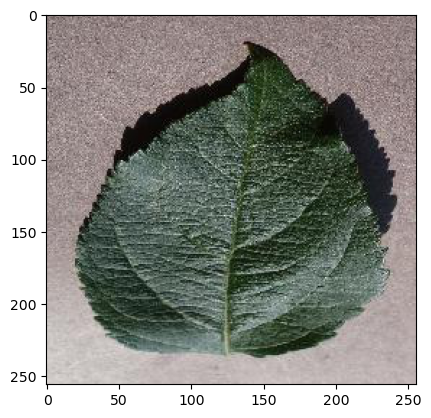

In [5]:
import matplotlib.image as mping
test_image = "crop-disease-data/healthy/1.jpg"
img = mping.imread(test_image)
plt.imshow(img)

In [6]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 1709 files belonging to 2 classes.
Using 1368 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 1709 files belonging to 2 classes.
Using 341 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['diseased', 'healthy']

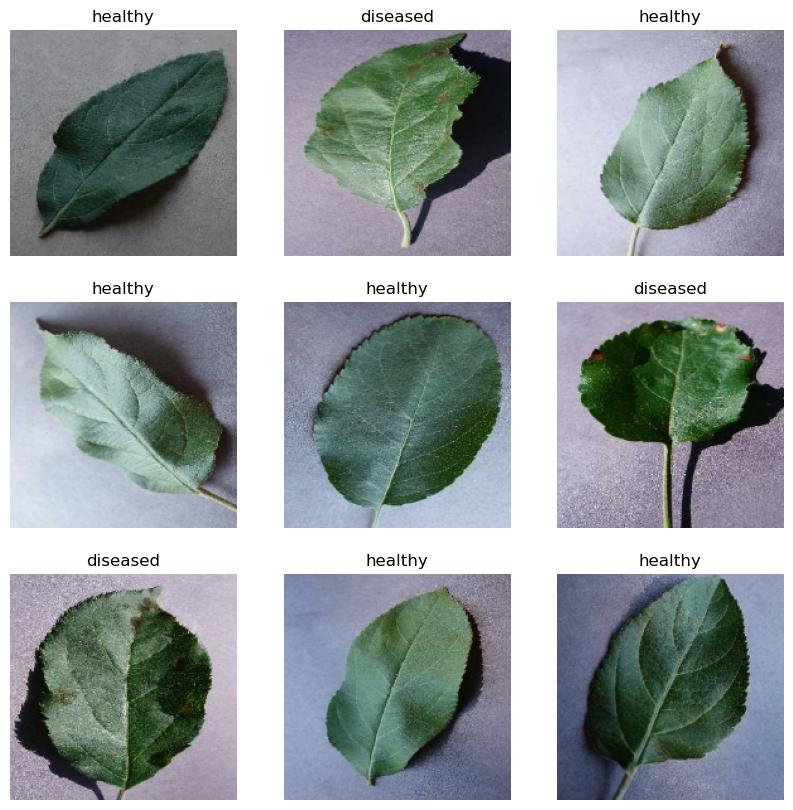

In [11]:
# Here are the first nine images from my training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [12]:
# manually iterate of the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [13]:
# configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Standardize values to be in the [0,1] RGB channel range by using tf.keras.Rescaling
normalization_layers = layers.Rescaling(1./255)

In [16]:
# create a keras model

num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [17]:
# compile our model

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [19]:
# train the model for 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
43/43 [==============================] - 65s 1s/step - loss: 0.6688 - accuracy: 0.6308 - val_loss: 0.4033 - val_accuracy: 0.8152
Epoch 2/10
43/43 [==============================] - 64s 1s/step - loss: 0.2878 - accuracy: 0.8830 - val_loss: 0.2627 - val_accuracy: 0.8856
Epoch 3/10
43/43 [==============================] - 61s 1s/step - loss: 0.2275 - accuracy: 0.9115 - val_loss: 0.2167 - val_accuracy: 0.9296
Epoch 4/10
43/43 [==============================] - 51s 1s/step - loss: 0.1969 - accuracy: 0.9196 - val_loss: 0.2228 - val_accuracy: 0.9091
Epoch 5/10
43/43 [==============================] - 48s 1s/step - loss: 0.1507 - accuracy: 0.9466 - val_loss: 0.1979 - val_accuracy: 0.9443
Epoch 6/10
43/43 [==============================] - 47s 1s/step - loss: 0.1653 - accuracy: 0.9342 - val_loss: 0.2088 - val_accuracy: 0.9267
Epoch 7/10
43/43 [==============================] - 49s 1s/step - loss: 0.1490 - accuracy: 0.9444 - val_loss: 0.2253 - val_accuracy: 0.9296
Epoch 8/10
43/43 [==

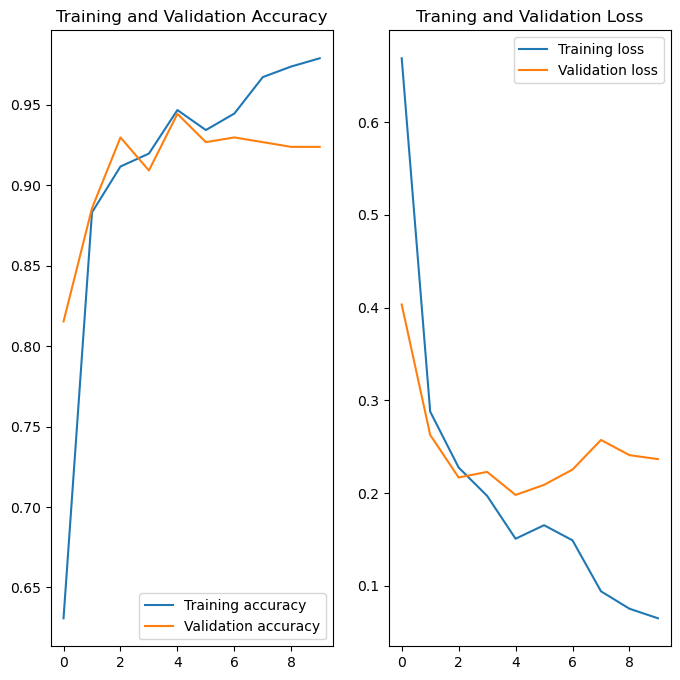

In [20]:
# visualize training results by creating plots for loss and accuracy on training and validation sets

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Traning and Validation Loss")
plt.show()

In [22]:
# Reduce overfitting through data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

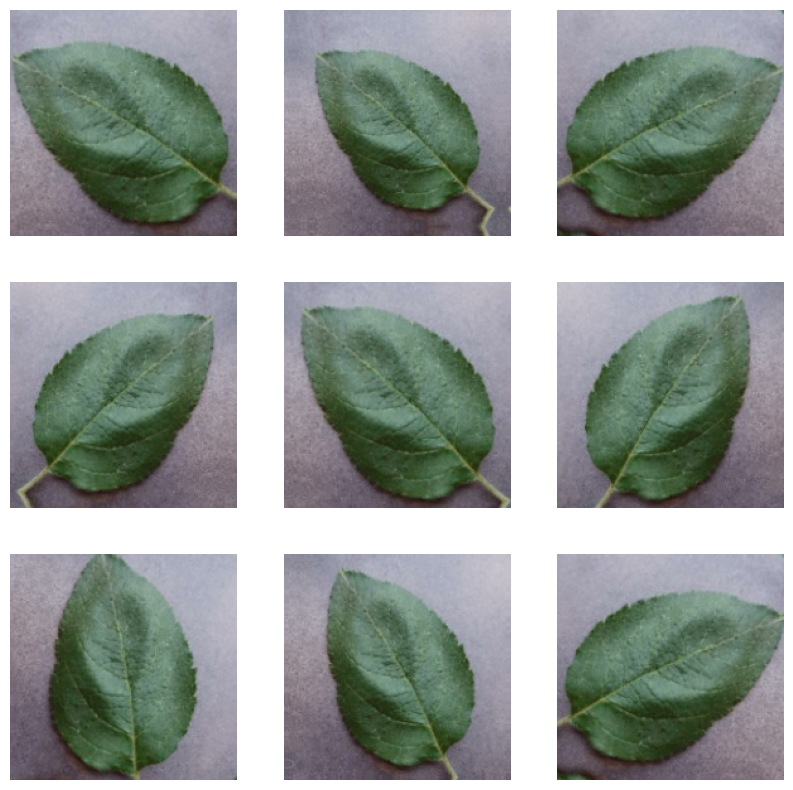

In [24]:
# visualize a few augmented examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [25]:
# introduce Dropout in the network to help reduce overfitting further

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='ouputs')
])

In [26]:
# compile and train the model

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [31]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
43/43 [==============================] - 58s 1s/step - loss: 0.0684 - accuracy: 0.9773 - val_loss: 0.2062 - val_accuracy: 0.9413
Epoch 2/15
43/43 [==============================] - 57s 1s/step - loss: 0.0658 - accuracy: 0.9766 - val_loss: 0.0540 - val_accuracy: 0.9795
Epoch 3/15
43/43 [==============================] - 66s 2s/step - loss: 0.0590 - accuracy: 0.9803 - val_loss: 0.0949 - val_accuracy: 0.9736
Epoch 4/15
43/43 [==============================] - 70s 2s/step - loss: 0.0704 - accuracy: 0.9671 - val_loss: 0.1158 - val_accuracy: 0.9501
Epoch 5/15
43/43 [==============================] - 64s 1s/step - loss: 0.0572 - accuracy: 0.9810 - val_loss: 0.1049 - val_accuracy: 0.9677
Epoch 6/15
43/43 [==============================] - 68s 2s/step - loss: 0.0402 - accuracy: 0.9846 - val_loss: 0.0437 - val_accuracy: 0.9795
Epoch 7/15
43/43 [==============================] - 65s 2s/step - loss: 0.0397 - accuracy: 0.9854 - val_loss: 0.1597 - val_accuracy: 0.9531
Epoch 8/15
43/43 [==

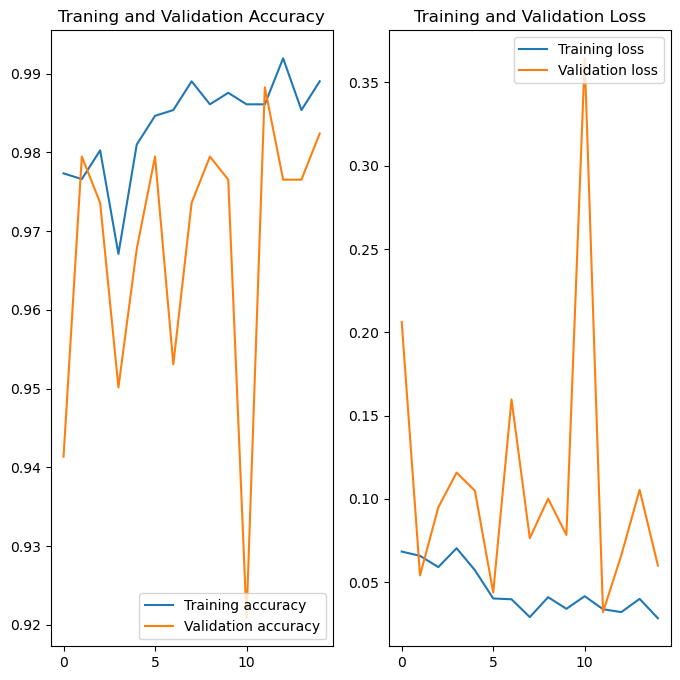

In [32]:
# Visualizing the training results

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Traning and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [35]:
# predict on new data
img = tf.keras.utils.load_img(
    "crop-disease-data/test.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100* np.max(score))
)

1/1 [==============================] - 1s 738ms/step
This image most likely belongs to diseased with a 100.00 percent confidence.
